In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
audio_path=[]
audio_emotion=[]
file_path='/content/drive/MyDrive/Speech_Emotion/RAVDESS'
all_paths=os.listdir(file_path)
for i in range(len(all_paths)):
  actor=all_paths[i]
  all_files=os.listdir(file_path+'/'+actor)
  for j in range(len(all_files)):
    emotion=int(list(all_files[j].split('-'))[2])
    audio_path.append(file_path+'/'+actor+'/'+all_files[j])
    audio_emotion.append(emotion)

In [ ]:
id2label={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}
label2id={}
for i in id2label.keys():
  label2id[id2label[i]]=i

In [ ]:
import numpy as np
import pandas as pd
audio_path_arr=np.array(audio_path)
audio_emotion_arr=np.array(audio_emotion)
audio_path_arr=np.reshape(audio_path_arr,(audio_path_arr.shape[0],1))
audio_emotion_arr=np.reshape(audio_emotion_arr,(audio_emotion_arr.shape[0],1))
df=pd.DataFrame(audio_path_arr,columns=['Path'])
df2=pd.DataFrame(audio_emotion_arr,columns=['ID'])
df=pd.concat([df,df2],axis=1)
df['ID']=df['ID']-1

In [ ]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


In [ ]:
df.to_csv('/content/drive/MyDrive/Speech_Emotion/RAVDESS.csv',index=False)

In [ ]:
!pip install datasets
from datasets import load_dataset, load_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 25.2 MB/s eta 0:00:00


In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/Speech_Emotion/RAVDESS.csv')
from sklearn.model_selection import train_test_split
train_dataset,val_dataset=train_test_split(dataset,test_size=0.3)
val_dataset,test_dataset=train_test_split(val_dataset,test_size=0.6)

In [ ]:
print(train_dataset['ID'].value_counts().sort_values())
num_labels=len(pd.unique(train_dataset['ID']))

0     68
2    130
1    131
3    132
5    135
7    136
6    137
4    139
Name: ID, dtype: int64


In [ ]:
#!pip uninstall transformers
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.5 MB/s eta 0:00:00


In [ ]:
!pip install pyctcdecode
from transformers import AutoConfig, AutoProcessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.9/414.9 kB 46.5 MB/s eta 0:00:00


In [ ]:
!pip install datasets
from datasets import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_ckpt="harshit345/xlsr-wav2vec-speech-emotion-recognition"
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    finetuning_task="wav2vec2_baseline",
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
from transformers import AutoFeatureExtractor

In [ ]:
processor = AutoFeatureExtractor.from_pretrained(model_ckpt)
target_sampling_rate=processor.sampling_rate

In [ ]:
import librosa

In [ ]:
import torchaudio
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = librosa.load(path,sr=target_sampling_rate)
    #resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    #speech = resampler(speech_array).squeeze().numpy()
    return speech_array

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label
#Callback function for preprocessing the data for the modeling
#returns processed audio by AudioProcessor of Wav2Vec2
def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples['Path']]
    result = processor(speech_list, sampling_rate=target_sampling_rate)
    return result

In [ ]:
train_dataset=train_dataset.to_dict(orient='list')
train_dataset=Dataset.from_dict(train_dataset)

val_dataset=val_dataset.to_dict(orient='list')
val_dataset=Dataset.from_dict(val_dataset)

test_dataset=test_dataset.to_dict(orient='list')
test_dataset=Dataset.from_dict(test_dataset)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
train_dataset = train_dataset.map(
      preprocess_function,
      batch_size=32,
      batched=True,
      num_proc=4)

Map (num_proc=4):   0%|          | 0/1008 [00:00<?, ? examples/s]

In [ ]:
 val_dataset = val_dataset.map(
      preprocess_function,
      batch_size=32,
      batched=True,
      num_proc=4
  )

Map (num_proc=4):   0%|          | 0/172 [00:00<?, ? examples/s]

In [ ]:
 test_dataset = test_dataset.map(
      preprocess_function,
      batch_size=32,
      batched=True,
      num_proc=4
  )

Map (num_proc=4):   0%|          | 0/260 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['Path', 'ID', 'input_values', 'attention_mask'],
    num_rows: 1008
})
Dataset({
    features: ['Path', 'ID', 'input_values', 'attention_mask'],
    num_rows: 172
})
Dataset({
    features: ['Path', 'ID', 'input_values', 'attention_mask'],
    num_rows: 260
})


In [ ]:
train_dataset=train_dataset.rename_column('ID','labels')
val_dataset=val_dataset.rename_column('ID','labels')

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

#Final return type of the model consisting of loss,logits,hidden_states,attentions
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

#Classification Head for the model
#returns final logits for the model
class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

#Model for Wav2Vec2 Classification
#returns loss,logits,hidden_states,attentions
class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, ckpt,config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.wav2vec2 = AutoModel.from_pretrained(ckpt)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)
        #print(logits.shape)
        loss = None
        if labels is not None:
          loss_fn = torch.nn.CrossEntropyLoss()
          loss = loss_fn(logits,labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output
        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from transformers import AutoModel

In [ ]:
model = Wav2Vec2ForSpeechClassification(ckpt=model_ckpt,config=config)

Some weights of the model checkpoint at harshit345/xlsr-wav2vec-speech-emotion-recognition were not used when initializing Wav2Vec2Model: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor

#Data collator that will dynamically pad the inputs received till the maximum length passed to the collator
@dataclass
class DataCollatorCTCWithPadding:


    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
import numpy as np
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
global preds_val
#Callback function for Trainer used to return Accuracy, precision and recall
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds)
    preds=np.argmax(preds,axis=1)
    acc=accuracy_score(p.label_ids,preds)
    prec=precision_score(p.label_ids,preds,average='micro')
    rec=recall_score(p.label_ids,preds,average='micro')
    return {"accuracy": acc,
            'precision':prec,
            'recall':rec}


In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 18.3 MB/s eta 0:00:00


In [ ]:
model.freeze_feature_extractor()
from transformers import TrainingArguments
#Training arguments for the model
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Speech_Emotion/wav2vec2-xlsr-greek-speech-emotion-recognition",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    learning_rate=1e-4,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
)

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast

#Trainer class with training_step function overridden
#returns loss
class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        model.train()
        inputs = self._prepare_inputs(inputs)
        inputs=inputs.to(device)
        loss=self.compute_loss(model,inputs)
        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps
        loss.backward()
        return loss.detach()

In [ ]:
print(train_dataset)

Dataset({
    features: ['Path', 'labels', 'input_values', 'attention_mask'],
    num_rows: 1008
})


In [ ]:
print(val_dataset)

Dataset({
    features: ['Path', 'labels', 'input_values', 'attention_mask'],
    num_rows: 172
})


In [ ]:
trainer = CTCTrainer(
    model=model.to(device),
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,No log,1.078220,0.587209,0.587209,0.587209
2,No log,0.638199,0.784884,0.784884,0.784884
3,No log,0.450362,0.843023,0.843023,0.843023


TrainOutput(global_step=252, training_loss=0.8956336975097656, metrics={'train_runtime': 300.1021, 'train_samples_per_second': 10.077, 'train_steps_per_second': 0.84, 'total_flos': 3.972824213081904e+17, 'train_loss': 0.8956336975097656, 'epoch': 3.0})

In [ ]:
test_dataset=test_dataset.rename_column('ID','labels')

In [ ]:
out=trainer.predict(test_dataset)
result=compute_metrics(out)

{'accuracy': 0.8615384615384616, 'precision': 0.8615384615384616, 'recall': 0.8615384615384616}


In [ ]:
preds = out.predictions[0] if isinstance(out.predictions, tuple) else out.predictions
preds = np.squeeze(preds)
preds=np.argmax(preds,axis=1)
gt=out.label_ids

In [ ]:
labels=[id2label[i] for i in range(num_labels)]
print(labels)

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [ ]:
gt=[id2label[i] for i in gt]
preds=[id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(gt,preds,labels=labels)

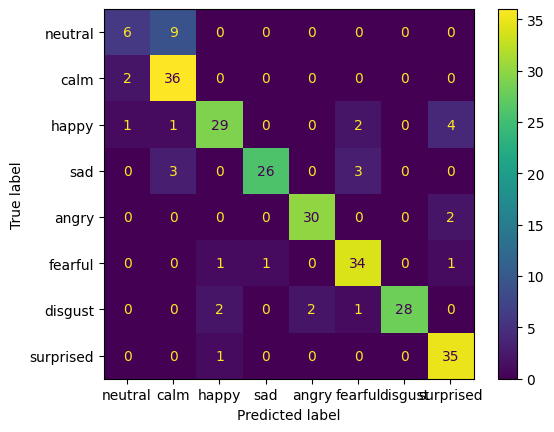

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=labels)
disp.plot()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Speech_Emotion/Pre_trained_Harshit')